In [317]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
from educationmodel_3 import EducationModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [318]:
model = EducationModel()

In [319]:
model.par.school_time_grid

array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20.])

In [320]:
model.par.experience_grid

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17.])

In [321]:
model.sol.V.shape

(11, 6, 15, 18, 5, 5, 5)

In [322]:
model.solve()

In [323]:
sol = model.sol

In [324]:
sol.d.mean()

0.062044444444444444

In [325]:
sol.d[1].mean()

0.14310617283950616

In [326]:
sol.d.shape

(11, 6, 15, 18, 5, 5, 5)

In [327]:
sol.d[0,5,14,:,:,:,:]

array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0.,

In [328]:
model.simulate()

In [329]:
sim=model.sim

In [330]:
mean_d_vectors =[]
mean_school_time_vectors = []
mean_wage_vectors = []
mean_experience_vectors = []

In [331]:
start = 0 
for i in range(model.par.Nfix):
    end = start + model.par.block_length
    mean_d = sim.d[start:end].mean(axis=0)
    mean_school_time = sim.school_time[start:end].mean(axis=0)
    mean_wage = sim.wage[start:end].mean(axis=0)
    mean_d_vectors.append(mean_d)
    mean_school_time_vectors.append(mean_school_time)
    mean_wage_vectors.append(mean_wage)
    mean_experience = sim.experience[start:end].mean(axis=0)
    mean_experience_vectors.append(mean_experience)
    start = end 


In [332]:
plot_vectors = [mean_d_vectors, mean_school_time_vectors, mean_wage_vectors, mean_experience_vectors]
vector_names = ["Mean schooling choice", "Mean school time", "Mean wage", "Mean experience"]

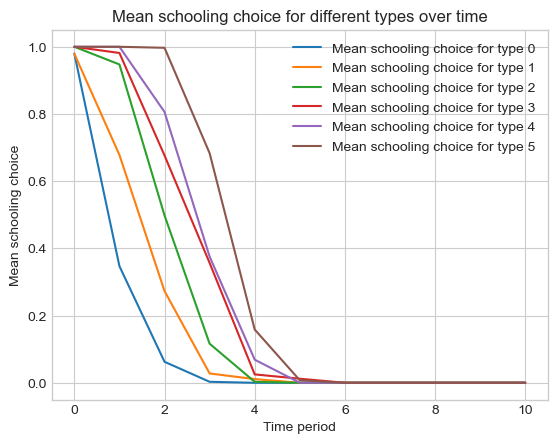

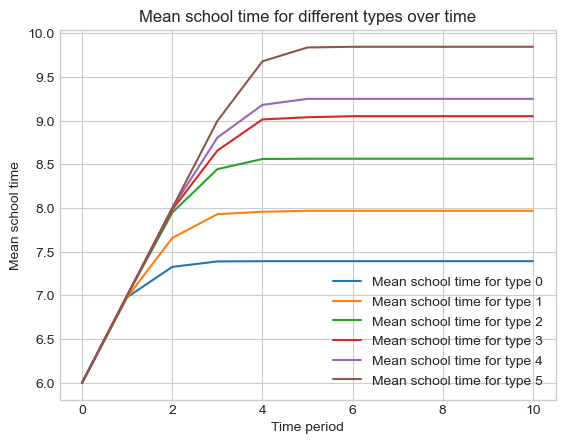

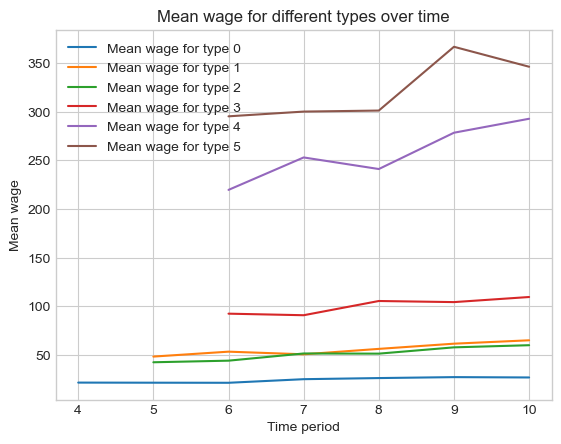

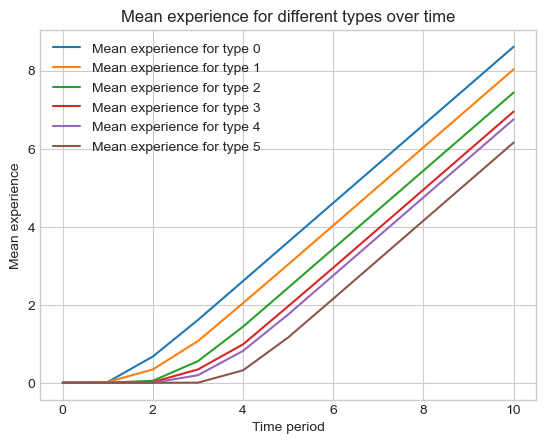

In [333]:
for vector, name in zip(plot_vectors, vector_names):
    for i in range(model.par.Nfix):
        plt.plot(vector[i], label=f"{name} for type {i}")
    plt.legend()
    plt.xlabel("Time period")
    plt.ylabel(name)
    plt.title(f"{name} for different types over time")
    plt.show()